In [1]:
import numpy as np
import random as rnd
import eq_functions as eq
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1756)
rnd.seed(1756)

# define parameters
Nt = 1000
Tf = 32 # unit time
a = np.log10(Nt)
b = 1.
c = 1.
cprime = 1.
p = 1.1
pprime = 1.8
Mc = 3.
smin = 0.7 # minimum seismicity allowable on an interval so that it doesn't get too small
k = 10**a * (1-p)/((c+Tf)**(1-p) - c**(1-p)) # k from Omori -needed for adaptive time increment 

In [2]:
# intended column order
cols = ['n_avg','Events','Magnitude','Distance','theta','Time']
events_occurred = 0 # number of earthquakes generated 
t = 0
while t < Tf: # iterate until reached end of forecast period
    dt = (-1/k * smin*(p-1) + (c+t)**(1-p))**(-1/(p-1)) - c - t # update time increment - set up so that seismicity is equal to smin at each interval
    # average seismicity rate on interval [t,t+dt]
    n_avg = eq.average_seismicity(t,t+dt,Tf,a,p,c)
    
    # generate number of events according to a Poisson process
    X = int((eq.sample_poisson(n_avg,1)))
    
    # assign each event a magnitude according to GR
    mgtds = eq.sample_magnitudes(X, Mc, b)
    
    # assign distances according to spatial Omori (with random azimuth angle)
    distances = eq.sample_location(X, cprime, pprime)
    thetas = np.random.uniform(0, 2*np.pi, X)
    
    # generate the times at which each event occurs - uniform random number on [t,t+dt]
    times = np.random.uniform(t, t+dt, X)
    times = np.sort(times)
    
    # store results in dataframe
    if t == 0: # initial dataframe, full dataframe constructed via concatenation in subsequent iterations
        # index label for current time interval
        if X != 0:
            interval = [''] * X
            interval[0] = ['Interval: [{:.2f},{:.2f}]'.format(t,t+dt)] # only include interval label on first row
            # create dataframe using dict of objects
            Xcol = ['']*X # only include number of events on first row
            Xcol[0] = X
            n_avgcol = ['']*X
            n_avgcol[0] = n_avg # only include average number of events on first row
            catalog = pd.DataFrame({'Magnitude': mgtds,
                                   'Events':Xcol,
                                   'n_avg':n_avgcol,
                                   'Distance':distances,
                                   'Time':times,
                                   'theta':thetas}, index = interval)
            catalog = catalog.reindex(columns = cols)
        else: # formatting for when there are no events during a time interval
            interval = ['Interval: [{:.2f},{:.2f}]'.format(t,t+dt)]
            catalog = pd.DataFrame({'Magnitude': ['-'],
                                      'Events':[X],
                                      'n_avg':[n_avg],
                                      'Distance':['-'],
                                      'Time':['-'],
                                      'theta':['-']}, index = interval)
            catalog = catalog.reindex(columns = cols)
    else: # join new results to existing catalog
        # index label for current time interval
        if X != 0: 
            interval = [''] * X
            interval[0] = ['Interval: [{:.2f},{:.2f}]'.format(t,t+dt)]# * X
            Xcol = ['']*X
            Xcol[0] = X
            n_avgcol = ['']*X
            n_avgcol[0] = n_avg
            catalog_update = pd.DataFrame({'Magnitude': mgtds,
                                      'Events':Xcol,
                                      'n_avg':n_avgcol,
                                      'Distance':distances,
                                      'Time':times,
                                      'theta':thetas}, index = interval)
            catalog_update = catalog_update.reindex(columns = cols)
        else: # formatting for when there are no events during a time interval
            interval = ['Interval: [{:.2f},{:.2f}]'.format(t,t+dt)]
            catalog_update = pd.DataFrame({'Magnitude': ['-'],
                                      'Events':[X],
                                      'n_avg':[n_avg],
                                      'Distance':['-'],
                                      'Time':['-'],
                                      'theta':['-']}, index = interval)
            catalog_update = catalog_update.reindex(columns = cols)
        frames = [catalog, catalog_update]
        catalog = pd.concat(frames)

    events_occurred += X # for comparing against Nt, intended catalog size
    t += dt # update time

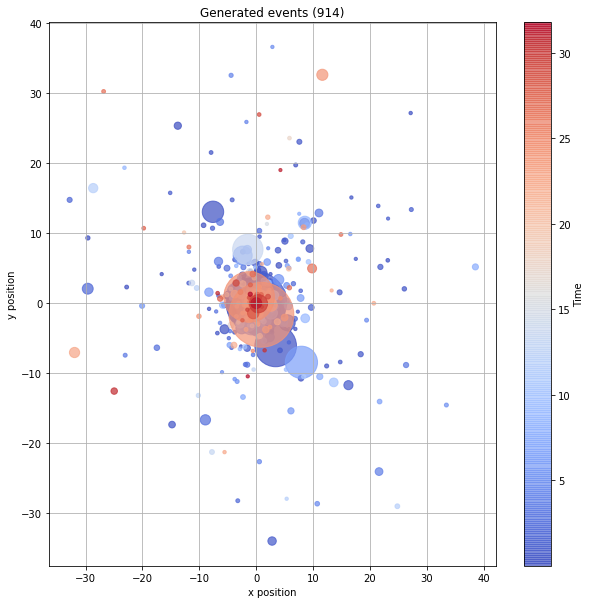

In [3]:
# Plotting the catalog

fig= plt.figure()
ax = fig.add_subplot(111)#, projection = 'polar')
fig.set_figheight(10)
fig.set_figwidth(10)

theta = catalog['theta']
try:    
    theta = theta.loc[theta != '-'] # when there are no intervals containing no events (marked by '-'), this comparison doesnt work. will look into better way of getting around it
except TypeError:
    pass
theta = np.array(theta, dtype = np.float) # needs to be float 

dist = catalog['Distance']
try:
    dist = dist.loc[dist != '-']
except TypeError:
    pass
dist = np.array(dist, dtype = np.float)
x = dist * np.cos(theta)
y = dist * np.sin(theta)


times = catalog['Time']
try:
    times = times.loc[times != '-']
except TypeError:
    pass
times = np.array(times, dtype = np.float)

magnitudes = catalog['Magnitude']
try:
    magnitudes = magnitudes.loc[magnitudes != '-']
except TypeError:
    pass
magnitudes = np.array(magnitudes, dtype = np.float)

plot = ax.scatter(x, y,
           c = times,
           s = 0.01*10**magnitudes, # large events much bigger than smaller ones
           cmap = 'coolwarm', alpha = 0.7)

cbar = fig.colorbar(plot)
cbar.set_label('Time')

plt.title('Generated events ({})'.format(events_occurred))
plt.ylabel('y position')
plt.xlabel('x position')
plt.grid(True)
plt.show()

#catalog.to_csv('catalog.csv')